# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Bagging](#Bagging)
- [Boosting](#Boosting)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Binary Classification: Day 5 - Error Analysis
- This notebook focuses on Analyzing the Error using Decision Boundaries

## Importing Libraries

In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *


from sklearn.metrics import roc_auc_score,recall_score,classification_report,roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold,cross_validate,cross_val_predict

In [2]:
train_data = pl.read_csv("balanced_train.csv")
test_data = pl.read_csv("balanced_test.csv")
train_data

SeniorCitizen,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,MonthlyCharges,TotalCharges,Streamer,Safer,Family,OnlinePayment,All,Churn
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
0,51,0,1,1,0,1,1,12,60.15,3077.0,1,1,1,0,1,0
0,5,0,2,0,0,0,0,12,20.1,85.1,0,0,1,0,0,0
0,28,0,0,0,0,0,0,1,81.05,2227.1,1,0,1,1,0,1
0,2,0,0,0,0,0,0,1,79.75,164.5,1,0,0,1,0,1
0,30,1,0,1,1,0,0,1,94.3,2679.7,1,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,23,1,0,0,0,0,0,1,84.65,2277.65,1,1,0,1,0,1
0,52,1,0,0,1,1,1,12,104.05,5426.85,1,1,0,0,0,1
0,35,1,0,0,1,1,0,1,75.35,2636.05,0,1,0,0,0,1


In [3]:
cat_cols=["SeniorCitizen","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","Contract","Streamer","Safer","Family","OnlinePayment","All"]
num_cols=train_data.drop(["Churn","customerID"]+cat_cols).columns

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.25,random_state=42,stratify=y_train)

Best parameters found: OrderedDict([('bootstrap', True), ('max_depth', 26), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
Best ROC AUC score: 0.9246860043123765
Mean Train roc auc Score: 0.9995705906521284
Mean Train recall Score: 0.9981415773241297

Mean Test roc auc Score: 0.9254080819398174
Mean Test recall Score: 0.8516534132199863
Recall score: 0.83
Correlation: 0.7017377183342722
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1031
           1       0.86      0.83      0.85      1031

    accuracy                           0.85      2062
   macro avg       0.85      0.85      0.85      2062
weighted avg       0.85      0.85      0.85      2062



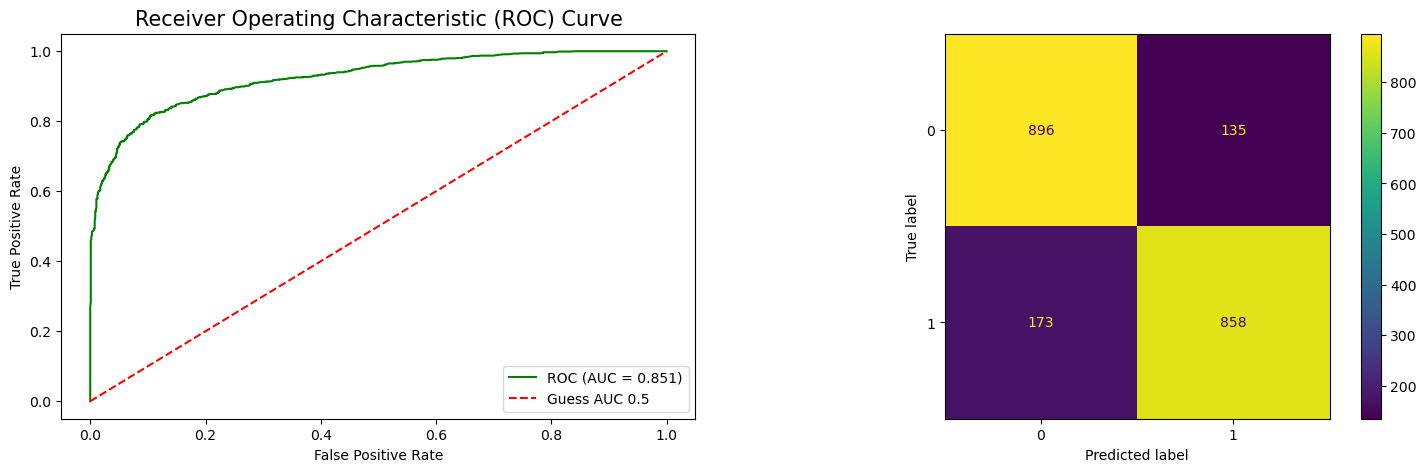

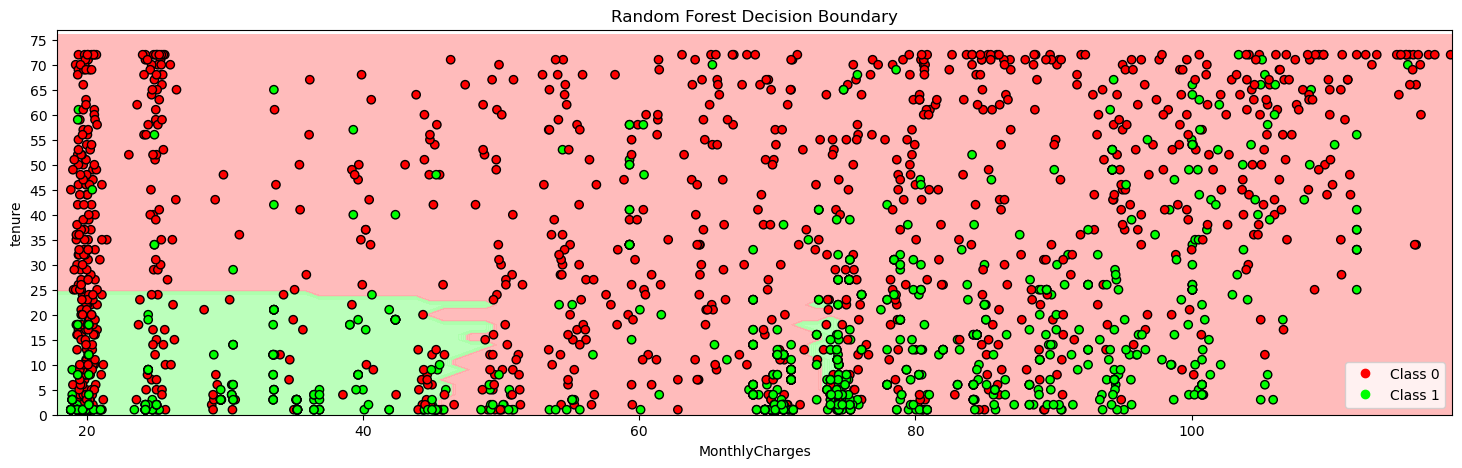

In [4]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer,Categorical

rf = RandomForestClassifier(random_state=42,n_jobs=-1)

# Define the hyperparameter search space
param_space = {
    'n_estimators': Integer(10, 1000),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'max_features': Categorical([None, 'sqrt', 'log2']),
    'bootstrap': Categorical([True, False])
}

# Initialize the BayesSearchCV
bayes_cv_tuner = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=50,
    cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42),
    n_jobs=-1,
    scoring='roc_auc',
    random_state=42
)

# Fit the model
bayes_cv_tuner.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {bayes_cv_tuner.best_params_}")
print(f"Best ROC AUC score: {bayes_cv_tuner.best_score_}")

# Evaluation with the best estimator
best_rf = bayes_cv_tuner.best_estimator_

cv_results = cross_validate(best_rf, X_train, y_train, cv=5, scoring=['recall', 'roc_auc'], n_jobs=-1, return_train_score=True, error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

# Evaluation on the test set
predictions_prob = cross_val_predict(best_rf, X_test, y_test, method='predict_proba', n_jobs=-1)
predictions = [0 if x < 0.5 else 1 for x in predictions_prob[:, 1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
coef = matthews_corrcoef(y_test, predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation: {coef}")
print("\033[4mClassification Report\033[0m\n", classification_report(y_test, predictions))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:, 1])
plot_evaluation(fpr, tpr, y_test, predictions, roc_auc)

# Visualize decision boundary (assuming plot_evaluation and decision_boundary functions are defined)
feature1 = 'MonthlyCharges'
feature2 = 'tenure'
decision_boundary(X_test, y_test, feature1, feature2, best_rf, transformer=None, title="Random Forest")

Learning rate set to 0.067197
0:	learn: 0.7988104	test: 0.7900134	best: 0.7900134 (0)	total: 152ms	remaining: 1m 16s
100:	learn: 0.8498655	test: 0.8352166	best: 0.8359191 (93)	total: 520ms	remaining: 2.05s
200:	learn: 0.8738325	test: 0.8497409	best: 0.8498824 (197)	total: 869ms	remaining: 1.29s
300:	learn: 0.8941176	test: 0.8514851	best: 0.8514851 (300)	total: 1.21s	remaining: 801ms
400:	learn: 0.9061654	test: 0.8555187	best: 0.8555187 (399)	total: 1.55s	remaining: 382ms
499:	learn: 0.9177337	test: 0.8514476	best: 0.8563300 (419)	total: 1.89s	remaining: 0us

bestTest = 0.8563300142
bestIteration = 419

Shrink model to first 420 iterations.
Mean Train roc auc Score: 0.9651497086484618
Mean Train recall Score: 0.9180128673375586

Mean Test roc auc Score: 0.9179703486280888
Mean Test recall Score: 0.8603754121793731
Recall score: 0.86
Correlation: 0.7129014383446034
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.86      0.86   

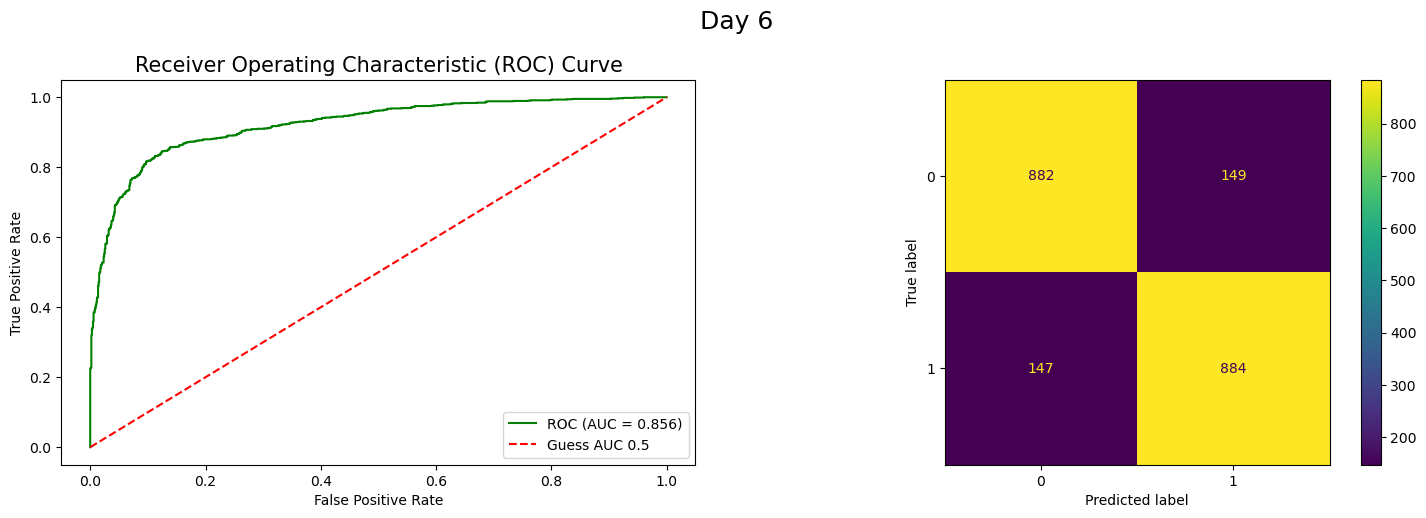

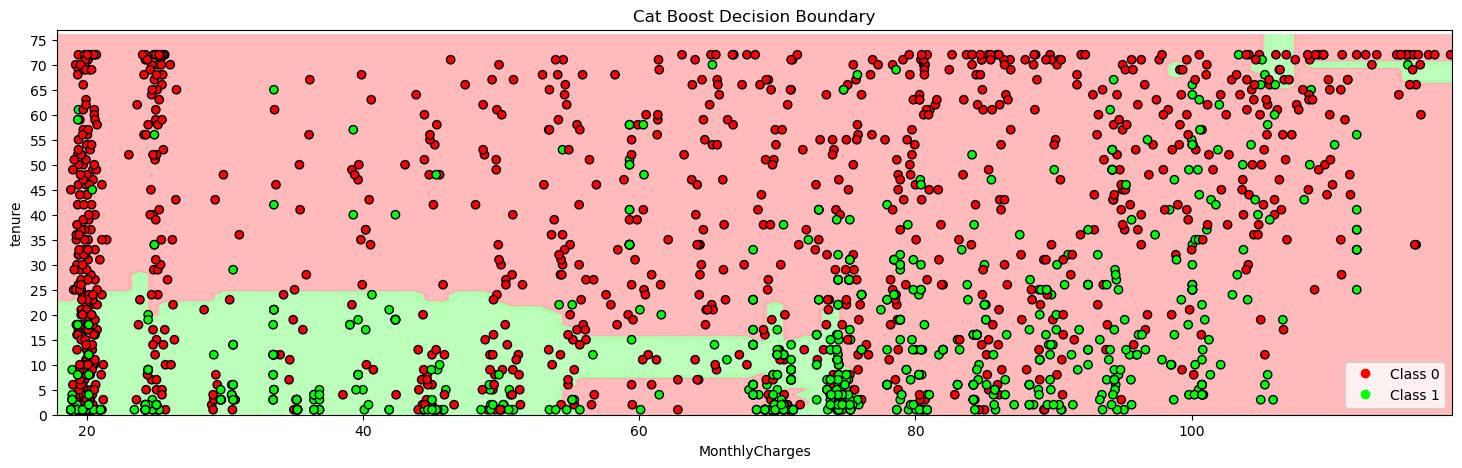

In [4]:
from catboost import CatBoostClassifier

rskf = RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)

cat=CatBoostClassifier(random_state=42, eval_metric='F1', verbose=100,n_estimators=500)

cat.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# Evaluation
cv_results = cross_validate(cat, X_train, y_train, cv=rskf, scoring=['recall', 'roc_auc'], n_jobs=-1, return_train_score=True, error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

predictions_prob = cross_val_predict(cat, X_test, y_test, method='predict_proba', n_jobs=-1)
predictions = [0 if x < 0.5 else 1 for x in predictions_prob[:, 1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
coef = matthews_corrcoef(y_test, predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation: {coef}")
print("\033[4mClassification Report\033[0m\n", classification_report(y_test, predictions))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:, 1])
plot_evaluation(fpr, tpr, y_test, predictions, roc_auc,title='Day 6')
feature1 = 'MonthlyCharges'
feature2 = 'tenure'
decision_boundary(X_test,y_test,feature1,feature2,cat,transformer=None,title="Cat Boost")

In [7]:
import joblib
joblib.dump(cat,"churn.pkl")

['churn.pkl']

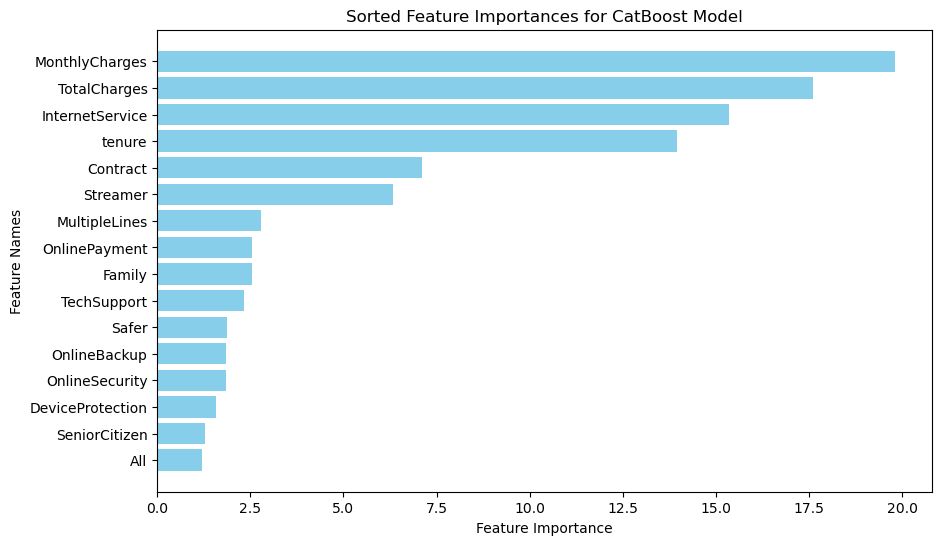

In [17]:
feature_importances = cat.get_feature_importance()
feature_names = cat.feature_names_

# Create a DataFrame to sort the importances
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Sorted Feature Importances for CatBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()


- Focusing on the important features. feature engineer can be done further for better performance

## Results
### Model Performance Summary (Day 6 - Final Models for Churn Prediction)

#### Model 1: Bagging using Random Forests

##### Cross-Validation Results

* **Mean Train ROC AUC Score**: 0.9988
* **Mean Train Recall Score**: 0.9817

* **Mean Test ROC AUC Score**: 0.9255
* **Mean Test Recall Score**: 0.8568

##### Holdout Set Performance

* **Recall Score on Holdout Set**: 0.83

##### Correlation

* **Correlation**: 0.6997

##### Classification Report on Holdout Set

|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0**   | 0.84      | 0.87   | 0.85     | 1031    |
| **Class 1**   | 0.86      | 0.83   | 0.85     | 1031    |
| **Accuracy**  |           | 0.85   |          | 2062    |
| **Macro Avg** | 0.85      | 0.85   | 0.85     | 2062    |
| **Weighted Avg** | 0.85   | 0.85   | 0.85     | 2062    |

#### Model 2: Boosting using CatBoost

##### Cross-Validation Results

* **Mean Train ROC AUC Score**: 0.9651
* **Mean Train Recall Score**: 0.9180

* **Mean Test ROC AUC Score**: 0.9180
* **Mean Test Recall Score**: 0.8604

##### Holdout Set Performance

* **Recall Score on Holdout Set**: 0.86

##### Correlation

* **Correlation**: 0.7129

##### Classification Report on Holdout Set

|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0**   | 0.86      | 0.86   | 0.86     | 1031    |
| **Class 1**   | 0.86      | 0.86   | 0.86     | 1031    |
| **Accuracy**  |           | 0.86   |          | 2062    |
| **Macro Avg** | 0.86      | 0.86   | 0.86     | 2062    |
| **Weighted Avg** | 0.86   | 0.86   | 0.86     | 2062    |

#### Insights

* **Performance Comparison**: Both models show strong performance metrics. The CatBoost model has slightly lower train ROC AUC (0.9651 vs. 0.9988) but more consistent performance on the test set and holdout set.
* **Generalization**: The Random Forest model shows signs of overfitting with a very high train ROC AUC score (0.9988) but a drop in the test ROC AUC (0.9255). The CatBoost model, with more balanced train (0.9651) and test (0.9180) ROC AUC scores, indicates better generalization.
* **Recall Scores**: Both models have high recall scores, crucial for churn prediction. CatBoost slightly outperforms on the holdout set recall (0.86) compared to Random Forest (0.83).
* **Precision-Recall Balance**: CatBoost maintains a better balance with both precision and recall at 0.86 for class 1 (churn), leading to higher reliability in identifying true churn cases.

#### Improvements from Previous Days

* **Increased Recall**: Both models show improved recall on the holdout set compared to previous results. This indicates better identification of churn cases.
* **Enhanced Generalization**: The CatBoost model in particular shows improved generalization from training to test data, a sign of robust model performance.
* **Higher Correlation**: The correlation metrics for both models (Random Forest: 0.6997, CatBoost: 0.7129) show a strong relationship between predicted probabilities and actual class labels, indicating reliable predictions.

#### Summary

* **Final Choice**: The CatBoost model is the recommended choice for deployment due to its robust performance, balanced precision and recall, and better generalization capabilities.
* **Future Steps**: Focus on continued improvement through feature engineering, hyperparameter tuning, and model monitoring to maintain and enhance predictive performance.

By selecting the CatBoost model and following these recommendations, the churn prediction system will provide reliable and actionable insights for improving customer retention strategies.

## Conclusion
- 86% of churners are identified with 86% precision (chance that our predicted churners are actually churners). Indicating most of our predicted churners are actual Churners